In [1]:
using Clustering, PyPlot
using TextAnalysis
using JLD2
using Statistics
using XLSX
using CSV
using DataFrames
using Dates
using LinearAlgebra
using StatsBase
using MultivariateStats
using Random

In [66]:
include("../src/utill.jl")

sel_top (generic function with 1 method)

In [3]:
new_df = XLSX.readxlsx("../data/Data-Spring/covid-de.xlsx")["Sheet1"]
stop_ind = new_df.dimension.stop;

en_1 = DataFrame(new_df["A2:$stop_ind"],  [:retweet_count, :favorite_count, 
        :created_at, :text, :id_str, 
        :lang])
mask_tmp = ones(Bool, length(en_1.id_str)) 
insert!(en_1, 7, mask_tmp, :tind)


new_df = XLSX.readxlsx("../data/Data-Winter/covid-de.xlsx")["Sheet1"]
stop_ind = new_df.dimension.stop;

en_2 = DataFrame(new_df["A2:$stop_ind"],  [:retweet_count, :favorite_count, 
        :created_at, :text, :id_str, 
        :lang]);

mask_tmp = zeros(Bool, length(en_2.id_str)) 
insert!(en_2, 7, mask_tmp, :tind)

min_dim = minimum([length(en_1.tind), length(en_2.tind)])

df = append!(en_1[1:min_dim, :], en_2[1:min_dim, :]);

# df = df[shuffle(1:length(df.favorite_count)), :]

## Preprocessing:

In [4]:
using Languages

In [26]:
function preprocess_corp(data)
    data_preprocessed = replace.(data, r"http\S+" => s"")
    data_preprocessed = replace.(data_preprocessed, r"\S+.com" => s"")
    data_preprocessed = replace.(data_preprocessed, r"resulting" => s"")
    data_preprocessed = replace.(data_preprocessed, r"RESULTING" => s"")
    data_preprocessed = replace.(data_preprocessed, r"#resulting" => s"")
    data_preprocessed = replace.(data_preprocessed, r"@\S+" => s"")
    data_preprocessed = replace.(data_preprocessed, r"&amp" => s"")
    data_preprocessed = replace.(data_preprocessed, r"RT\S+" => s"");

    crps_tmp = Corpus(StringDocument.(deepcopy(data_preprocessed)));

    languages!(crps_tmp, Languages.German())
    remove_case!(crps_tmp)
    prepare!(crps_tmp, strip_punctuation)
    prepare!(crps_tmp, strip_numbers)
    
#     prepare!(crps_tmp, strip_articles)
#     prepare!(crps_tmp, strip_pronouns)
#     prepare!(crps_tmp, strip_prepositions)
#     prepare!(crps_tmp, strip_definite_articles)
#     prepare!(crps_tmp, strip_indefinite_articles)

#     prepare!(crps_tmp, strip_stopwords)
#     prepare!(crps_tmp, strip_non_letters)
    
    remove_words!(crps_tmp, ["don", "re", "ve", "ll", "covid", "coronavirus", "corona", "mehr", "deutschland", "gibt", "schon", "heute", "immer", "viele", "coronavirusde", 
            "warum", "macht", "wurde", 
            "wäre", "bitte", "covidde", 
            "ganz", "gerade", "kommt",     
            "einfach", "sarscov",  "eigentlich", "beim", "geht", "neue", "unsere", "weitere", "sollen", "wirklich"]) 
    remove_words!(crps_tmp, unique([articles(Languages.German()); stopwords(Languages.German()); prepositions(Languages.German()); pronouns(Languages.German())]))
    

    
    stem!(crps_tmp)
    prepare!(crps_tmp, strip_whitespace)
    update_lexicon!(crps_tmp)
    return crps_tmp
end

preprocess_corp (generic function with 1 method)

In [27]:
crps = preprocess_corp(df[:,4])

A Corpus with 79390 documents:
 * 79390 StringDocument's
 * 0 FileDocument's
 * 0 TokenDocument's
 * 0 NGramDocument's

Corpus's lexicon contains 89892 tokens
Corpus's index contains 0 tokens

In [28]:
TextAnalysis.text.(crps[1:10])

10-element Array{String,1}:
 "nzz wiss « senkt kost pro leb » kris tragt bereit dunn firnis zivilisation schweiz medi darub diskutiert menschenleb kost darf"
 "vermisst meist"
 "losungsmodell baut beobacht menschheit zwei gross problem steht armut klimawandel wachsend wirtschaft wachsend bip unbedingt anzeich wirtschaft gesund"
 "wer aufgezeichnet fussballspiel anschaut derdiejen kontroll seinihr leb verlor gerarg"
 "bundesprasident coronakris welt steinmei glaubt europa solidaritatdarum braucht euich nie daran zweifelt👍 🇪🇺"
 "irgendwi ulkig knapp jahr gross gesellschaft probl brennend kirch frankreich notredam"
 "ziel kurv coviderkrank abzuflach darf – janer schirm formuliert – fuhr „ danach feststell bleibt platt via"
 "erst punkt ja mal verkackt ne \u2066 international council of nurs veroffentlicht prioritatenlist bekampf dbfk"
 "sech stund mal ganz coronamediendreck seel gekarchert landleb"
 "bundesprasident frankwalt steinmei burgerinn burg coronakris geduld disziplin solidaritat

In [29]:
# crps_1 = preprocess_corp(df[df.tind,4])
# crps_2 = preprocess_corp(df[.!df.tind,4]);

In [30]:
# Create a vector from merged corpus: 

lexicone_vect = lexicon(crps)

n_max = 300
pairs = sort(collect(lexicone_vect), by=x->x[2], rev=true)[1:n_max]
terms = [i[1] for i in pairs]

terms_mask = [length(term)>3 for term in terms]
terms = terms[terms_mask];

In [31]:
terms[1:20]

20-element Array{String,1}:
 "lockdown"
 "mensch"
 "coronakris"
 "schul"
 "zahl"
 "polit"
 "aktuell"
 "zeit"
 "erst"
 "pandemi"
 "jahr"
 "wurd"
 "massnahm"
 "land"
 "fall"
 "weihnacht"
 "impfstoff"
 "woch"
 "lockdownjetzt"
 "virus"

In [32]:
terms[21:40]

20-element Array{String,1}:
 "merkel"
 "kind"
 "mask"
 "gesund"
 "frag"
 "wenig"
 "infiziert"
 "wirtschaft"
 "person"
 "berlin"
 "halt"
 "test"
 "lang"
 "coronapandemi"
 "dank"
 "locker"
 "gross"
 "wichtig"
 "positiv"
 "impfung"

In [33]:
# # Create a vector from different datasets: 

# lexicone_vect_1 = lexicon(crps_1)
# lexicone_vect_2 = lexicon(crps_2)

# n_max = 200
# pairs_1 = sort(collect(lexicone_vect_1), by=x->x[2], rev=true)[1:n_max]
# terms_1 = [i[1] for i in pairs_1]

# pairs_2 = sort(collect(lexicone_vect_2), by=x->x[2], rev=true)[1:n_max]
# terms_2 = [i[1] for i in pairs_2]

# terms = unique([terms_1 ; terms_2])

# length(terms)

In [47]:
m = DocumentTermMatrix(crps, terms)

A 79390 X 248 DocumentTermMatrix

In [48]:
D = convert.(Float64, dtm(m, :dense)')

# D[:,df.tind] = D[:,df.tind] ./ sum(D[:,df.tind])
# D[:,.!df.tind] = D[:,.!df.tind] ./ sum(D[:,.!df.tind]);

In [49]:
# PCA:

M = fit(PCA, D; maxoutdim=5)
Yte = MultivariateStats.transform(M, D)

5×79390 Array{Float64,2}:
 -0.105676   -0.0961924  -0.0958378  …  -0.131448   -0.095117   -0.0708074
  0.0665644   0.0673885   0.0347923     -0.899101    0.0806571   0.0483902
  0.0704255   0.0514547   0.069901      -0.0963334   0.0525393   0.107275
  0.0481316   0.0403462   0.335345       0.255478    0.0440979  -0.251792
  0.0565707   0.0810158  -0.776282      -0.153464    0.0777263  -0.24122

In [50]:
# Independent Component Analysis:

# M = fit(ICA, D, 5)
# Yte = MultivariateStats.transform(M, D)

In [51]:
n_clusters = 5
cl = kmeans(Yte, n_clusters, tol=10^-8);
cl_assignments = cl.assignments;

In [52]:
# vars = (Yte, cl_assignments, M, D)
# JLD2.@save "../data/tmp_files/de.jld" vars

In [53]:
JLD2.@load "../data/tmp_files/de.jld" vars
(Yte, cl_assignments, M, D) = vars ;

In [54]:
cvals= log.(1 .+ df.favorite_count)
avals = 1 .+ df.retweet_count ; avals = log.(avals); avals = avals .- (minimum(avals) - 0.1) ; avals = avals ./ maximum(avals)
avals_t = [df.tind[i] == 1 ? plt.cm.Blues_r(avals[i]) : plt.cm.Reds_r(avals[i]) for i in eachindex(df.tind)];

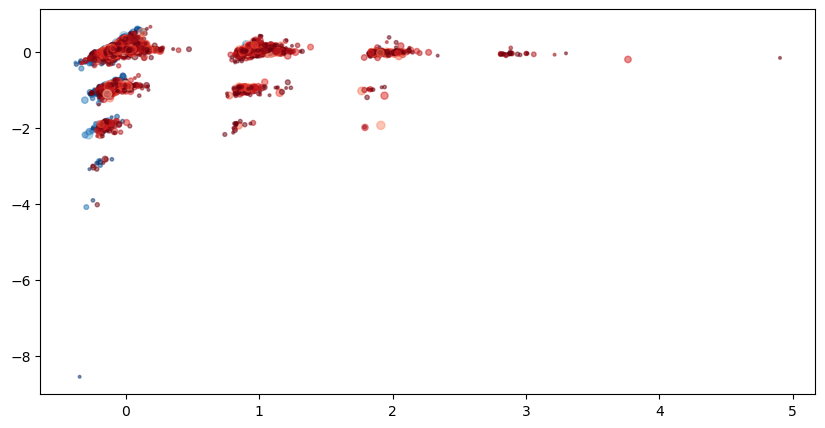

PyObject <matplotlib.collections.PathCollection object at 0x7f9674ed7d90>

In [55]:
fig, ax= plt.subplots(1,1, figsize=(10,5))

ax.scatter(Yte[1,:], Yte[2,:], alpha=0.5, s=5.5.*cvals, c=avals_t, rasterized=true)

# ax.scatter(1, 1, alpha=1, edgecolors="none", linewidths=0.0,  s=50, color=plt.cm.Blues_r(0.5), rasterized=true, label="April")
# ax.scatter(1, 1, alpha=1, edgecolors="none", linewidths=0.0, s=50, color=plt.cm.Reds_r(0.5), rasterized=true, label="December")

# ax.set_xlim(-1.2, 5)
# ax.set_ylim(-4.7, 1.2)


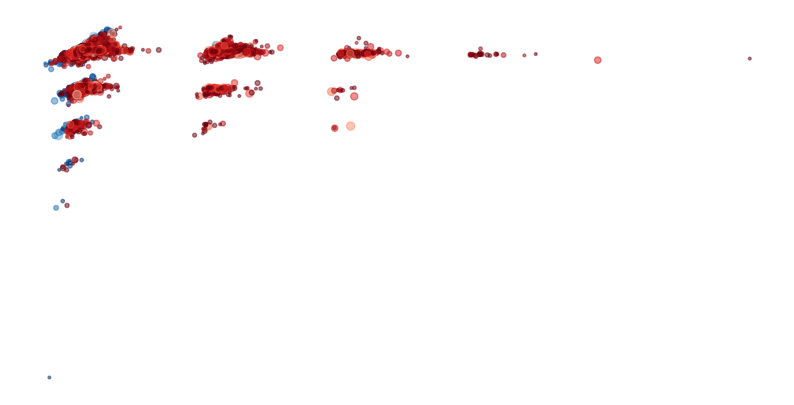

No handles with labels found to put in legend.


In [56]:
fig, ax= plt.subplots(1,1, figsize=(10,5))

ax.scatter(Yte[1,:], Yte[2,:], alpha=0.5, s=5.5.*cvals, c=avals_t, rasterized=true)

# ax.scatter(1, 1, alpha=1, edgecolors="none", linewidths=0.0,  s=50, color=plt.cm.Blues_r(0.5), rasterized=true, label="April")
# ax.scatter(1, 1, alpha=1, edgecolors="none", linewidths=0.0, s=50, color=plt.cm.Reds_r(0.5), rasterized=true, label="December")

# ax.set_xlim(-1.2, 5)
# ax.set_ylim(-4.7, 1.2)

ax.legend(loc="lower right", edgecolor="white", facecolor="white", framealpha=1.0) 

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")

ax.set_xticks([])
ax.set_yticks([]);

ax.set_xticklabels([])
ax.set_yticklabels([]);

ax.set_axis_off()

# fig.savefig("../plots/2d-samples-de-1.pdf", bbox_inches = "tight", dpi=600)

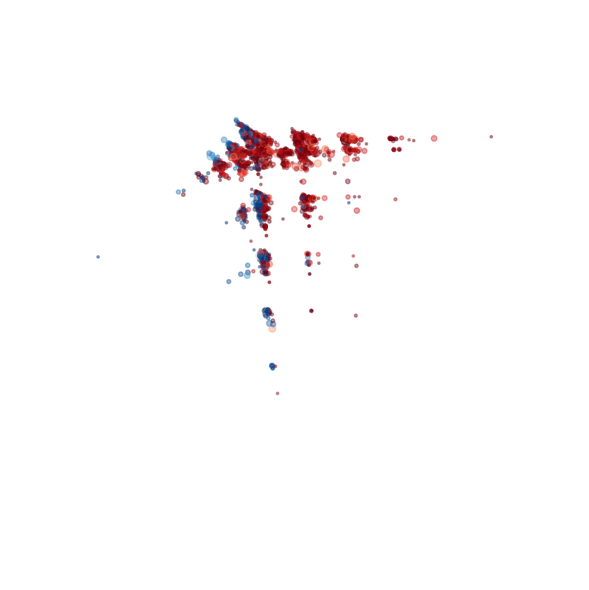

In [57]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection="3d")

ax.scatter(Yte[1,:], Yte[2,:], Yte[3,:],  alpha=0.4, s=4.0.*cvals, c=avals_t, rasterized=true, label="April") 

# ax.set_xlabel("PC 1")
# ax.set_ylabel("PC 2")
# ax.set_zlabel("PC 3")

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([]);

# ax.set_xlim(0.2, 7)
# ax.set_ylim(-0, 7)
# ax.set_zlim(-3.5, 0)

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# ax.w_xaxis.gridlines.set_lw(0.5)
# ax.w_yaxis.gridlines.set_lw(0.5)
# ax.w_zaxis.gridlines.set_lw(0.5)

ax.view_init(elev=10.,) # azim=-10

ax.set_box_aspect((1, 1, 1))
ax.set_axis_off()

fig.tight_layout()

# fig.savefig("../plots/3d-samples-de.pdf", bbox_inches = "tight", dpi=800)

In [58]:
# fig, ax = plt.subplots(1,1, figsize=(7,5))

# clst_tmp = unique(cl_assignments)

# for (ind, val) in enumerate(clst_tmp)
#     cl_mask = cl_assignments .== val
#     ax.scatter(Yte[1,cl_mask], Yte[2,cl_mask], s=3, color=plt.cm.hsv(ind/length(clst_tmp)), alpha=0.8, ) 
# end

# ax.set_xlabel("PC 1")
# ax.set_ylabel("PC 2")

# ax.set_xticklabels([])
# ax.set_yticklabels([]);

# # ax.set_axis_off()

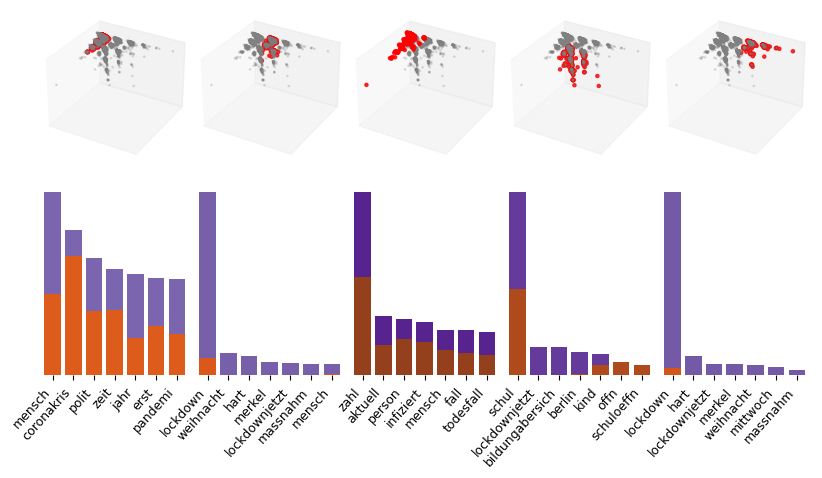

In [65]:
# Oranges - Begining 
# Purples - End

figure = make_plots(Yte, D, terms, cl_assignments, df.tind, df.retweet_count, ); #size=(15,15)

In [63]:
# figure.savefig("../plots/words-clusters-de.pdf", bbox_inches = "tight")

In [68]:
sorted_top = sel_top(df, cl_assignments)

,clust_id,favorite_count,created_at,text
,Int64,Any,Any,Any
1,1,5442,2020-04-17T10:46:00,In NRW darf ab Montag Ikea wieder öffnen. \nOder wie das #Coronavirus sagt: Entdecke die Möglichkeiten!
2,1,2949,2020-04-14T06:30:00,Ein katholischer Pfarrer aus der Nähe von Detroit hat die Osterkörbe seiner Gemeindemitglieder an einem Drive-in-Schalter mit Weihwasser aus einer Wasserpistole gesegnet. #WirvsVirus #Coronavirus #COVID19 https://t.co/CtJKJPNubp
3,1,2720,2020-04-13T10:36:59,"Einfacher und drastischer kann man es nicht darstellen, weshalb Covid-19 nicht mit einer schweren Grippe vergleichbar ist. https://t.co/cuJEdrkm55"
4,1,2323,2020-04-17T10:49:26,"“The telecon between @ImranKhanPTI &amp; @AngelaMerkelCDU did contribute in G20’s decision to provide #DebtRelief, during #coronavirus #pandemic, to weaker economies”, said #German Ambassador H.E Bernhard Schlagheck during #SDPIPolicyDialogue_COVID19\nDanke für den Beitritt zu uns. https://t.co/SVYmhXXB3K"
5,1,2319,2020-04-15T11:01:46,Ardern will angesichts der #Coronavirus-Pandemie sechs Monate lang auf 20 Prozent ihres Gehalts verzichten. Die Kürzung gelte auch für ihre Minister sowie Spitzenbeamte im öffentlichen Dienst. #COVID19 #WirvsVirus https://t.co/i3XpADfMC3
6,1,2148,2020-04-13T11:31:43,"Die Christusstatue in Rio de Janeiro wurde in der Osternacht beleuchtet, um das medizinische Personal in Brasilien und in der ganzen Welt zu würdigen, das gegen die Ausbreitung des #Coronavirus kämpft. #COVID19 #WirvsVirus https://t.co/PDdiEWoTrW"
7,1,2073,2020-04-14T09:04:49,"Wenn ihr heute über #Lockerungen nachdenkt, gerade für Schulkinder, hilft euch vielleicht folgende Information: Eine Nachbarin ist heute an Covid-19 verstorben.\n48 Jahre alt. 3 Kinder\n2 davon Schulkinder\nVorerkrankung: Asthma.\nSie hat sich als Bäckereifachverkäuferin angesteckt."
8,1,2007,2020-04-17T18:02:03,"Immer mehr Studien weisen darauf hin, dass die Feinstaubbelastung ein Risikofaktor für schwere Verläufe mit Todesfolge durch Covid-19 ist. Feinstaub könnte wie ein Brandbeschleuniger wirken. Das ist relevant für Arbeitsplatz und die Verkehrsnähe Wohnort https://t.co/ogNMfZFOl3"
9,1,1801,2020-04-17T09:55:07,"Fachkrankenpflegerin Anästhesie erklärte mir gestern, Covid-19 sei bloß wie ne Grippe und es ärgere sie maßlos, dass nur deswegen ihre Hochzeit platze.\nBeim Bäcker erzählt die Verkäuferin, sie habe ja im September so flachgelegen, das sei GARANTIERT bereits Covid gewesen.\n\nWTF???"


In [69]:
# XLSX.writetable("../data/upload/Data-Clusters-Equal/sorted-de.xlsx", collect(DataFrames.eachcol(sorted_top)), DataFrames.names(sorted_top))